In [40]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

np.random.seed(123)  # For reproducibility

In [2]:
'''
PARAMETERS
'''

#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small (affinity)
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #MAX uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a

print(c)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [ ]:
'''
MODEL 1 : CR_model
'''

# complete model
def CR_model(t, y, c, K, w, l, m, g, d, D):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a]) # uptake ~ max uptake, resource concentration, affinity

  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)]) # growth ~ uptake, energy content of resource, leakage, maintenance
                                                                                 # -> sum of every resource
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake, dilution rate

  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake
                                                                  # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a] # production ~ fraction converted, energy content, leakage, population, uptake
    byproduction = np.sum(byproduction_tot) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction # resource evolution ~ dilution, consumption, byproduct production

  return np.concatenate((dNdt,dRdt))

In [ ]:
t_span = (0,100)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [ ]:
#solution of the model
c[0,0] = 0.5
c[1,0] = 0.75
c[2,0] = 0
c[3,1] = 0
c[1,1] = 0
c[2,1] = 0.2
c[0,1] = 0.2
c[0,2] = 0.1
c[1,2] = 0
c[2,2] = 0.6
c[3,2] = 0
c[0,3] = 0
c[1,3] = 0.2
c[2,3] = 0
c[3,3] = 0
print(c)

solutions = solve_ivp(CR_model, t_span, y0, args=(c, K, w, l, m, g, d, D), method = "BDF")

[[0.5  0.2  0.1  0.   1.   1.   1.   1.   1.   1.  ]
 [0.75 0.   0.   0.2  1.   1.   1.   1.   1.   1.  ]
 [0.   0.2  0.6  0.   1.   1.   1.   1.   1.   1.  ]
 [1.   0.   0.   0.   1.   1.   1.   1.   1.   1.  ]]


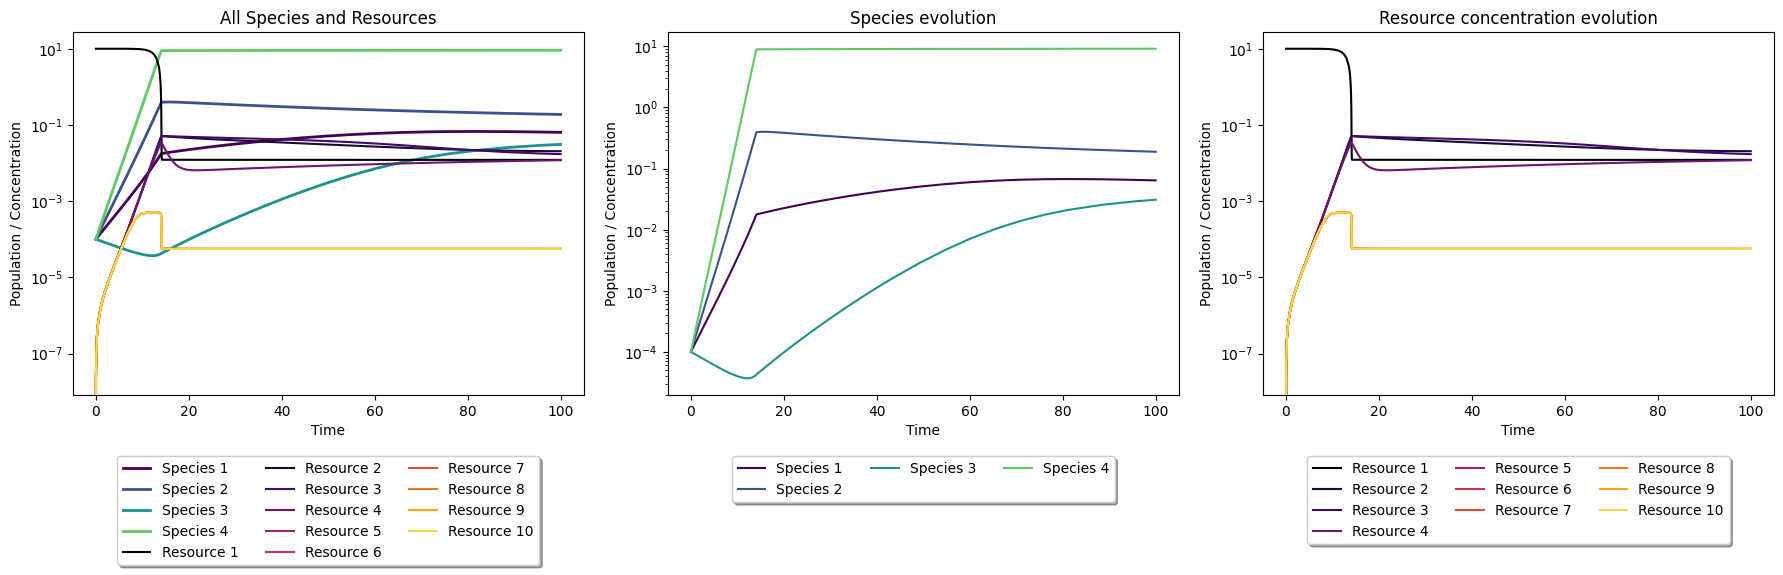

In [ ]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
#Randomisation of some parameters
#c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)


In [ ]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")

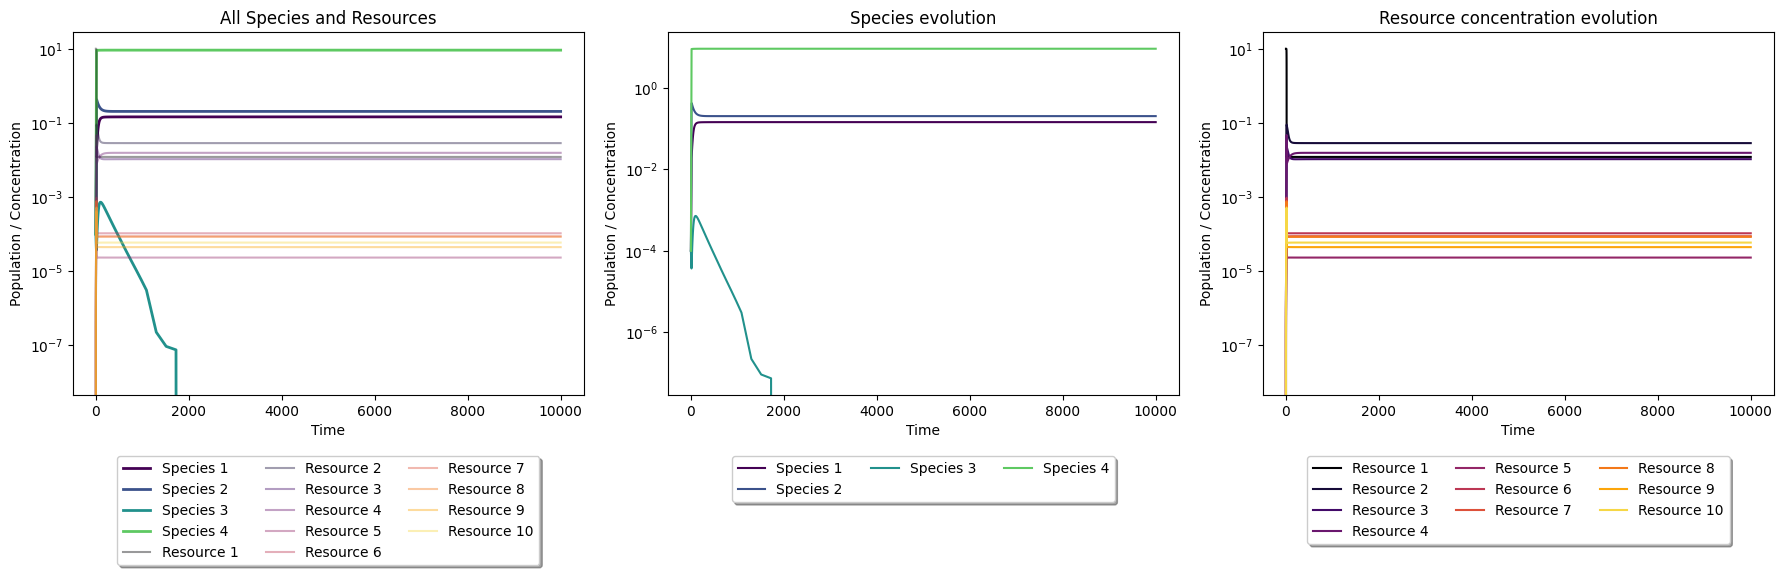

In [ ]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
#random multiple simulations
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for i in range(20):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


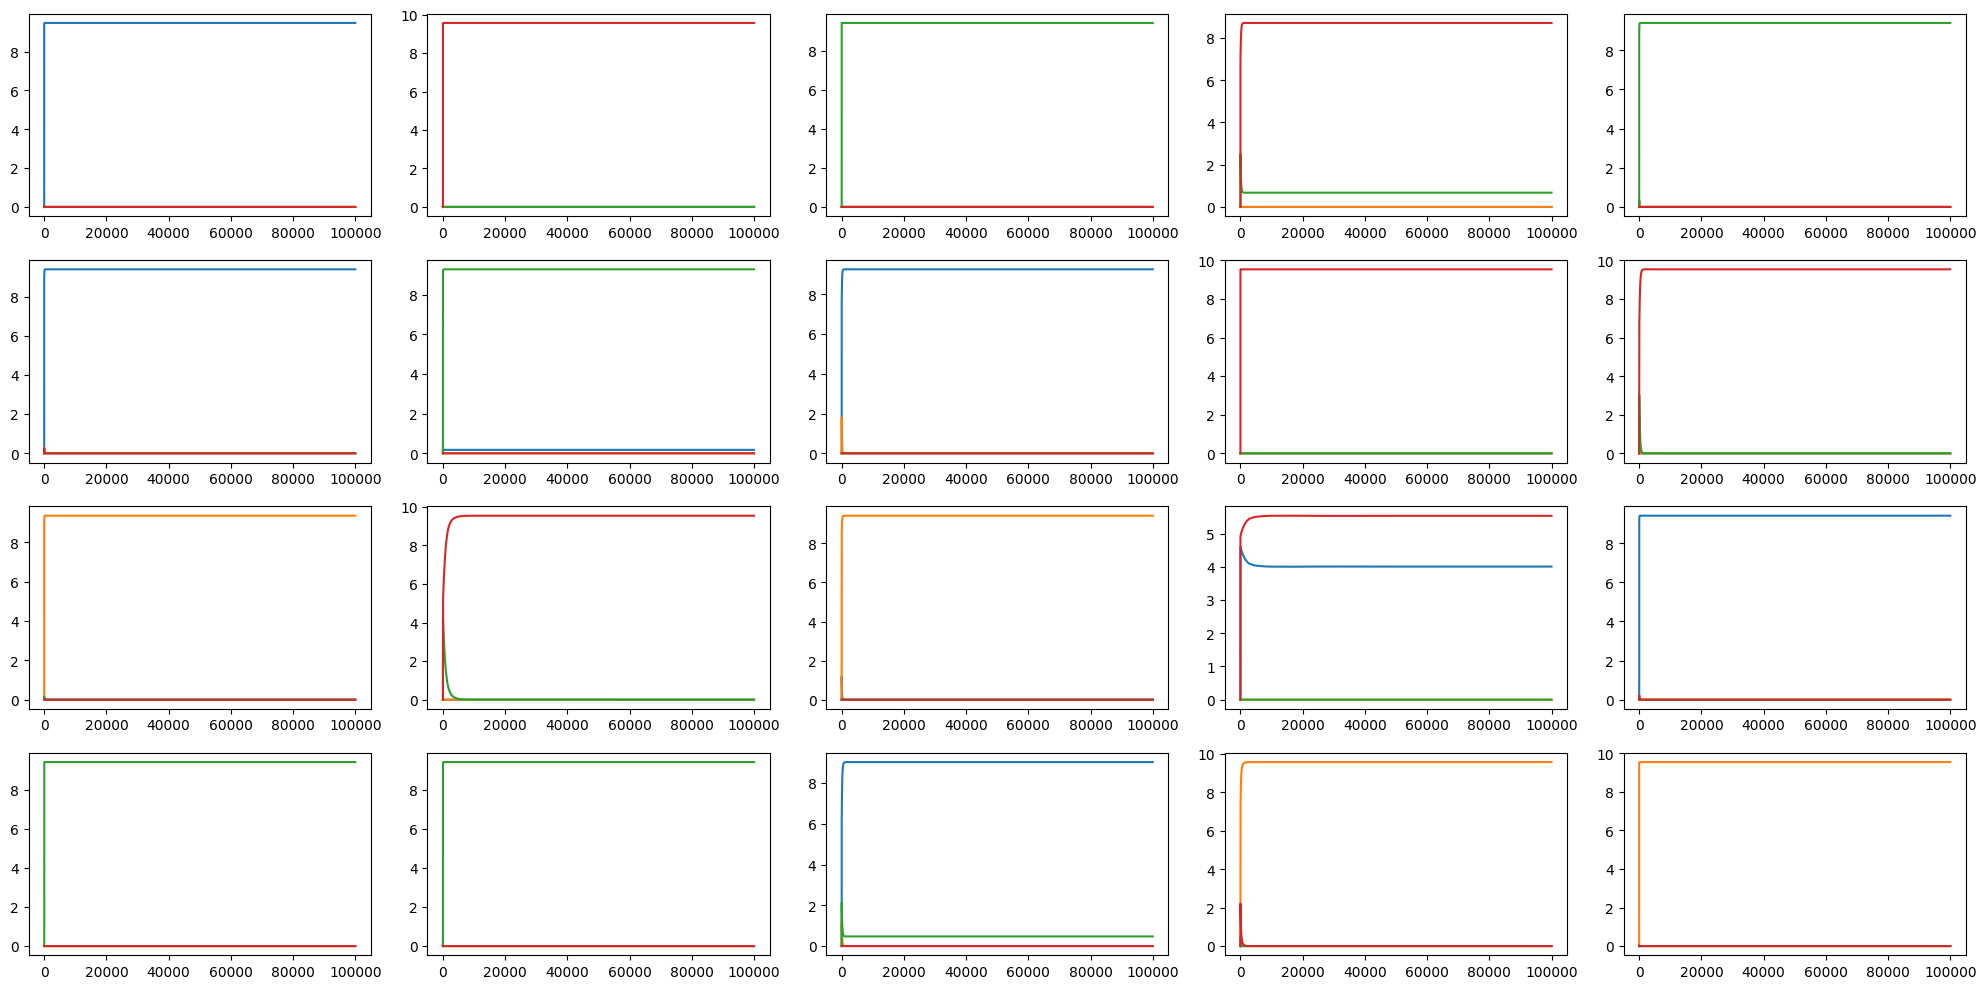

In [ ]:
#plotting usinage
#trash

fig, axs = plt.subplots(4,5,figsize = (20,10))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()


In [43]:
'''
MODEL 2 : CR_model_simple
- 3 cs, 3 species (keep it simple)
- w = 1, m = 0, l=0, d=0
- vary K ? and other parameters ?
- (arbitrary values)
'''

# PARAMETERS

# starting population and resource densities -> 3 species and 3 cs for the simple model
n_species = 3
N0 = np.array([1e-1, 1e-2, 5e-2]) # list of INITIAL POPULATION densities for species 1,2,3

n_cs = 3 # cs = carbon sources
R0 = np.array([10, 20, 15]) # list of INITIAL CONCENTRATION of resources 1,2,3


y0 = np.append(np.array(N0),R0) # starting state

'''
#FINE TUNING OF g
g = np.ones(n_species) # CONVERSION FACTOR from energy uptake to growth rate, for each species
g = np.array([0.25, 0.5, 0.5]) # for species 1,2,3
'''


#RANDOMIZATION OF g
for i in range(n_species):
    g[i] = np.random.rand()

K = np.ones(n_cs) # AFFINITY of each resource (consider making this small)
K = np.array([0.01, 0.02, 0.01]) # for resource 1,2,3

'''
# FINE TUNING OF c
c =  np.ones((n_species,n_cs)) # MAX UPTAKE of a ressource a by a species i
c = np.array([[0.8, 0.5, 1.0],  # species 1, resource 1,2,3
              [1.0, 0.8, 0.5],  # species 2, resource 1,2,3
              [0.5, 1.0, 0.8]]) # species 3, resource 1,2,3
'''

# RANDOMIZATION OF c
for i in range(n_species) :
  for j in range(n_cs):
    c[i, j] = np.random.rand()  # Randomize c for each species and resource


D = np.zeros((n_species, n_cs, n_cs)) # BYPRODUCT produced by species a from resource i attention to no go beyond a sum of one for each column
# Production by species 1
'''
FINE TUNING OF D
D[0] = [
    [0.05, 0, 0],   # byproduct 1 from resources 1, 2, 3
    [0, 0.075, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.1]     # byproduct 3 from resources 1, 2, 3
]
# Production by species 2
D[1] = [
    [0.125, 0, 0],  # byproduct 1 from resources 1, 2, 3
    [0, 0.15, 0],   # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.175]   # byproduct 3 from resources 1, 2, 3
]
# Production by species 3
D[2] = [
    [0.2, 0, 0],    # byproduct 1 from resources 1, 2, 3
    [0, 0.225, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.25]    # byproduct 3 from resources 1, 2, 3
]
'''

'''
RANDOM BYPRODUCTION
'''
for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()  # Randomize the scaling to ensure the sum is less than 1

d = 0.1 # dilution (=decay)

In [38]:
# MODEL
def CR_model_simple(t,y) :

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values

  # resource uptake
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i, a] = c[i, a] * R[a] / (R[a] + K[a]) # uptake ~ max uptake, resource concentration, affinity

 # population variation
  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum(J[i, :]) # growth ~ uptake, energy content of resource // NO LEAKAGE, NO MAINTENANCE                                                                             # -> for every resource, added up
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake // with dilution (else population will never decrease and we won't be able to determine in wich case it doesn't)

  # resource variation
  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake

    # byproduct formation                                                                 # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i, b] = D[i, a, b] * N[i] * J[i, b] # production ~ fraction converted, energy content, population, uptake // NO LEAKAGE, NO VAR IN RESOURCE ENERGY CONTENT
    byproduction = np.sum(byproduction_tot[:, a]) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a]) - consumption + byproduction # resource evolution ~ consumption, byproduct production // NO DILUTION

  return np.concatenate((dNdt,dRdt))

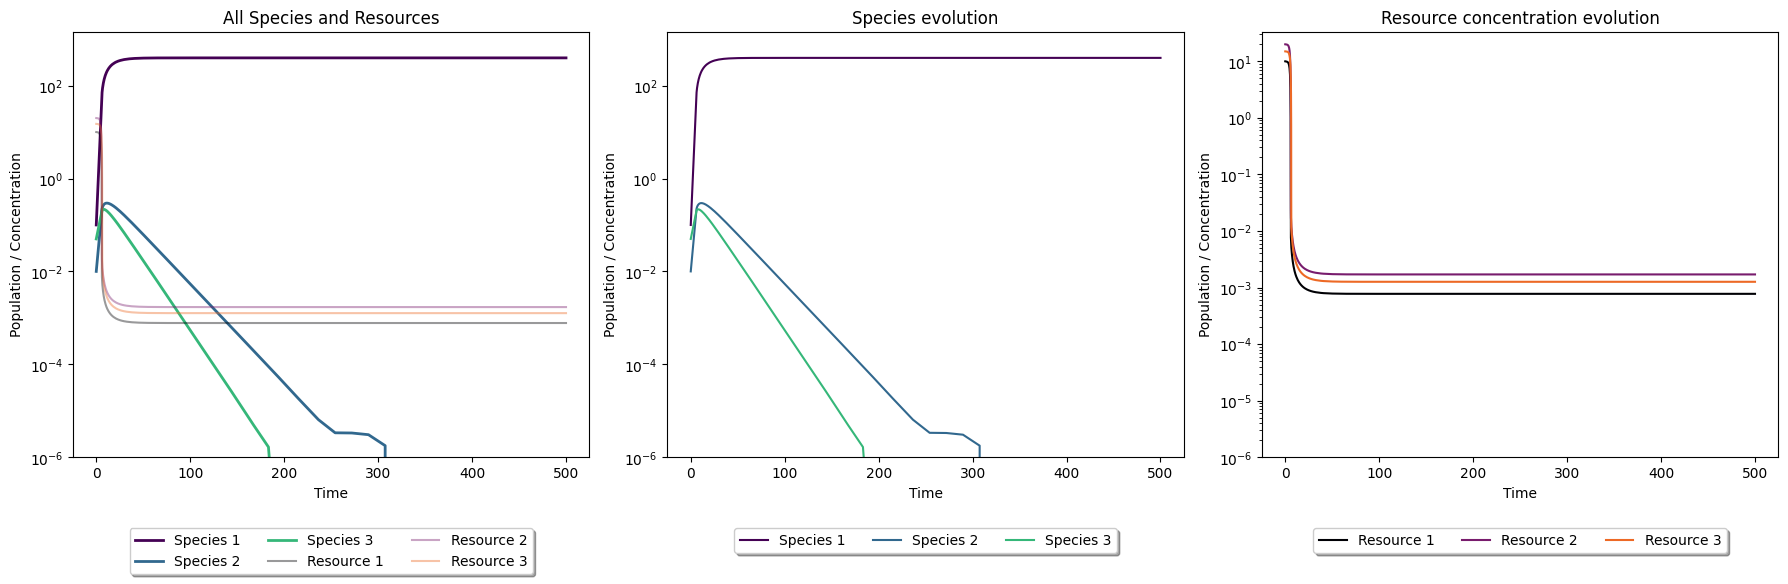

In [39]:
# DEFINE TIMEFRAME, SEARCH SOLUTIONS
t_span = (0,500)
solutions_simple = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")


# PLOT SOLUTIONS
legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)
    ax.set_ylim(bottom=1e-6) # anything below is considered absent


plt.tight_layout()
plt.show()
f2 = solutions_simple.y[1][-1:]
f3 = solutions_simple.y[2][-1:]

In [ ]:
'''
Cohabitation possible when g*growth_intake is equivalent between species
'''

In [ ]:
'''
#trash

cohabitation_data = {"sim":[], "c" :[], "D" : []}

domination_data = {"sim":[],"c":[], "D":[]}

for i in range(len(sim_dict)):
  index_alive = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-9:
      index_alive.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][1])
  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][1])

cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
cohabitation_df.head()
'''

,sim,c,D
0,simulation 6,"[[0.617717294134677, 0.9234976778858535, 0.809...","[[[0.021499689314613712, 0.024784175563907596,..."
1,simulation 17,"[[0.8729339876298323, 0.3746203051488183, 0.64...","[[[0.09593624839266304, 0.019755662525108478, ..."


In [ ]:
# Statistical analysis
#trash
'''
sum_cohab = np.array([i.flatten() for i in cohabitation_df["D"]])
sum_domi = np.array([i.flatten() for i in domination_df["D"]])
pca = PCA(n_components=5)
t_stat, p_value = mannwhitneyu(sum_cohab, sum_domi)
p_value
'''

'\nsum_cohab = np.array([i.flatten() for i in cohabitation_df["D"]])\nsum_domi = np.array([i.flatten() for i in domination_df["D"]])\npca = PCA(n_components=5)\nt_stat, p_value = mannwhitneyu(sum_cohab, sum_domi)\np_value\n'

In [ ]:
# banque of c for simulation
'''
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
c_temp = c.copy()
c_banq = []
for i in range(n_species):
  for j in range (10):
    c_temp[i,i] -=0.1
    c_banq.append(c_temp)

t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)

sim_dict = {}
for i in range(len(c_banq)):
  c = c_banq[i]
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]
'''

'\nc =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i\nc_temp = c.copy()\nc_banq = []\nfor i in range(n_species):\n  for j in range (10):\n    c_temp[i,i] -=0.1\n    c_banq.append(c_temp)\n\nt_span = (0,10000)\nt_eval = np.linspace(t_span[0], t_span[1],300)\n\nsim_dict = {}\nfor i in range(len(c_banq)):\n  c = c_banq[i]\n  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")\n  sim_dict[f"simulation {i}"] = [[c,D],sol]\n'

In [41]:
'''
fig, axs = plt.subplots(10,4,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()
'''

'\nfig, axs = plt.subplots(10,4,figsize = (20,20))\n\nfor ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):\n  ax.plot(value[1].t, value[1].y[0], label=\'Species 1\')\n  ax.plot(value[1].t, value[1].y[1], label=\'Species 2\')\n  ax.plot(value[1].t, value[1].y[2], label=\'Species 3\')\n  ax.plot(value[1].t, value[1].y[3], label=\'Species 4\')  #ax.set_yscale("log")\nplt.tight_layout()\nplt.show()\n'

In [46]:
'''
TEST plotly
'''

# Résolution du modèle
t_span = (0, 500)
solution = solve_ivp(
    lambda t, y: CR_model_simple(t, y,),
    t_span,
    y0,
    method = 'BDF'
)

# Création des graphiques avec Plotly
fig = go.Figure()

# Premier graphique avec toutes les espèces et ressources
for i in range(n_species):
    fig.add_trace(go.Scatter(x=solution.t, y=solution.y[i], mode='lines', name=f'Species {i+1}'))
for i in range(n_cs):
    fig.add_trace(go.Scatter(x=solution.t, y=solution.y[i+n_species], mode='lines', name=f'Resource {i+1}', line=dict(dash='dash')))
fig.update_layout(title='All Species and Resources', xaxis_title='Time', yaxis_title='Population / Concentration', yaxis_type='log')

# Deuxième graphique avec seulement les espèces
fig2 = go.Figure()
for i in range(n_species):
    fig2.add_trace(go.Scatter(x=solution.t, y=solution.y[i], mode='lines', name=f'Species {i+1}'))
fig2.update_layout(title='Species evolution', xaxis_title='Time', yaxis_title='Population', yaxis_type='log')

# Troisième graphique avec seulement les ressources
fig3 = go.Figure()
for i in range(n_cs):
    fig3.add_trace(go.Scatter(x=solution.t, y=solution.y[i+n_species], mode='lines', name=f'Resource {i+1}', line=dict(dash='dash')))
fig3.update_layout(title='Resource concentration evolution', xaxis_title='Time', yaxis_title='Concentration', yaxis_type='log')

# Affichage des graphiques
fig.show()
fig2.show()
fig3.show()